## Sesion 7: Sistema recomendador de películas

Vamos a construir un sistema recomendador de películas sin usar librerías específicas (existen algunas como surprise https://surpriselib.com/). 

Cargaremos los datos de una base de datos de películas llamada Movielens (https://grouplens.org/datasets/movielens/).

Para representar los datos vamos a usar dataframes de Pandas (https://pandas.pydata.org/). Pandas es una de las principales librerías de análisis de datos de Python. Las estructuras más utilizadas en Pandas son las _Series_ y los _DataFrames_. 
Las _Series_ son objetos correspondientes a paneles unidimensionales, y los _DataFrames_ son paneles bidimensionales compuestos por filas y columnas, que permiten relacionar distintas variables. El formato de estas estructuras puede compararse con una hoja de cálculo de Excel o con los diccionarios de Python donde las claves son los nombres de las columnas y los valores son _Series_. 
Vamos a usar [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.html)

Se proporciona un notebook aparte con un tutorial detallado de pandas por si tienes dificultades para entender como se usa en este notebook. 

Para visualizar los datos usaremos otras librerías muy útiles y conocidas como [matplotlib](https://matplotlib.org/) y [seaborn](https://seaborn.pydata.org/).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Cargamos los datos y realizamos un análisis exploratorio de los mismos

El primer paso es descargar una versión del conjunto de datos (parte de los datos de MovieLens) que están disponibles en el campus en los archivos: 
- ratings.csv
- movies.csv
Los archivos contienen 100000 ratings de 600 usuarios aplicadas a 9000 peliculas. 
Con la librería pandas podemos cargarlos de forma muy sencilla en un _DataFrame_ usando read_csv.

In [4]:
ratings = pd.read_csv('ratings_movies.csv')

In [5]:
movies = pd.read_csv('movies.csv')

In [6]:
# observamos la estructura de las tablas mostrando las primeras filas con head()
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Por ejemplo, podemos buscar una película si sabemos su nombre con la siguiente función:

In [7]:
def movie_finder(title):
    return movies[movies['title'].str.contains(title)]['title'].tolist()

movie_finder('Toy Story')

['Toy Story (1995)', 'Toy Story 2 (1999)', 'Toy Story 3 (2010)']

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Observa cómo se accede a una Serie de Datos seleccionando una columna del Dataframe

In [9]:
title_movies = movies['title']

In [10]:
title_movies

0                                Toy Story (1995)
1                                  Jumanji (1995)
2                         Grumpier Old Men (1995)
3                        Waiting to Exhale (1995)
4              Father of the Bride Part II (1995)
                          ...                    
9737    Black Butler: Book of the Atlantic (2017)
9738                 No Game No Life: Zero (2017)
9739                                 Flint (2017)
9740          Bungo Stray Dogs: Dead Apple (2018)
9741          Andrew Dice Clay: Dice Rules (1991)
Name: title, Length: 9742, dtype: object

In [ ]:
##Vamos a filtrar los ratings para quedarnos solo con valoraciones que corresponden a la peliculas del data set (numeradas del 0 al 9741) 
ratings = ratings.loc[ratings['movieId'] <= 9741]

Podemos contar los elementos distintos con la función Series.nunique(dropna=True) (el parámetro indica si ignorar los valores NaN).

In [11]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()
print(f"Numero de ratings: {n_ratings}")
print(f"Numero de movieId's: {n_movies}")
print(f"Numero de users: {n_users}")
print(f"Número medio de ratings por usuario: {round(n_ratings/n_users, 2)}")
print(f"Número medio de ratings por película: {round(n_ratings/n_movies, 2)}")

Numero de ratings: 100836
Numero de movieId's: 9724
Numero de users: 610
Número medio de ratings por usuario: 165.3
Número medio de ratings por película: 10.37


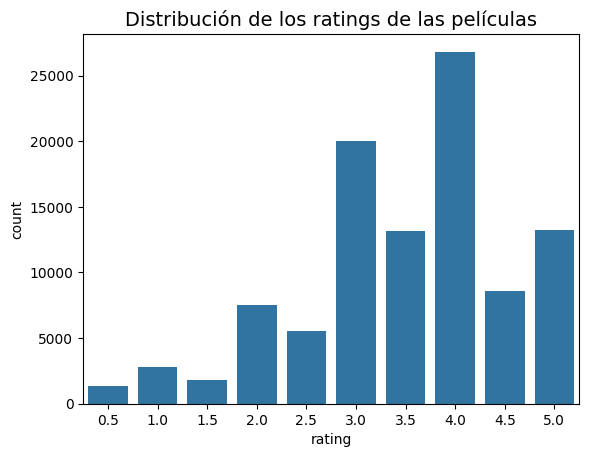

In [12]:
#sns.countplot(x="rating", data=ratings, palette="viridis")
sns.countplot(x="rating", data=ratings)
plt.title("Distribución de los ratings de las películas", fontsize=14)
plt.show()

In [ ]:
print(f"Rating global medio: {round(ratings['rating'].mean(),2)}.")
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Ratio medio por usuario: {round(mean_ratings.mean(),2)}.")

### 1. Recomendador basado en popularidad
Vamos a hacer un primer recomendador básico basado en popularidad. 
Medimos la popularidad de las películas para saber cuál es la mejor y peor película, es decir, qué película tiene la media de ratings más alta y más baja. 

In [13]:
# primero sacamos la media de ratings de cada película.
mean_ratings = ratings.groupby('movieId')[['rating']].mean()

In [14]:
mean_ratings

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
...,...
193581,4.000000
193583,3.500000
193585,3.500000


In [15]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [16]:
lowest_rated = mean_ratings['rating'].idxmin()
# idxmin devuelve el indice del mínimo (o de la primera vez que aparece) en la serie seleccionada.
# Ahora seleccionamos la fila de movies correspondiente a ese valor de ratio.
movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


La película `Gypsy` tiene el rating medio más bajo. Su movieId es el 3604

In [17]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


La película `Lamerica` (cuyo movieId es 53) tiene el valor de ratio más alto porque su media de valoraciones es 5.

Con este análisis un recomendador basado en popularidad recomendaría `Lamerica` y consideraría que `Gypsy` es una película muy poco recomendable. Si observamos un poco más los datos podemos concluir que esta recomendación no sería muy justa porque  `Gypsy` ha sido votada una única vez y `Lamerica` ha sido votada solo 2 veces. Debemos normalizar y ajustar la recomendación al número de valoraciones, por ejemplo, la película The Godfather tiene 192 valoraciones y aunque su media no llega a ser 5.0 es más popular y sería una mejor recomendación ¿Cómo podemos saber que cuántas veces ha sido votada una película? ¿Cómo podemos ajustar la popularidad usando esta información?

In [18]:
movies[movies['movieId'] == 53]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [19]:
# ratings de la película Lamerica. 
ratings[ratings['movieId'] == 53]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [20]:
# ratings de la película gypsy. 
ratings[ratings['movieId'] == 3604]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


In [21]:
movies[movies['movieId'] == 858]

,movieId,title,genres
659,858,"Godfather, The (1972)",Crime|Drama


In [22]:
# ratings de la pelicula The Godfather.
ratings[ratings['movieId'] == 858]

,userId,movieId,rating,timestamp
1453,15,858,4.0,1510571941
1587,16,858,2.5,1377476772
1688,17,858,5.0,1305696683
1836,18,858,4.0,1455050024
3253,21,858,2.5,1376823648
...,...,...,...,...
96280,603,858,5.0,953926758
97486,606,858,4.0,1171234955
98524,607,858,4.0,963078880
98831,608,858,5.0,1117408367


Vamos a usar otra aproximación mejor para evaluar la popularidad de las películas usando __la media bayesiana__ [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average) que no está afectada por el número de valoraciones. La media bayesiana es un concepto relacionado con la estadística y la teoría de probabilidad que se utiliza para calcular la media de una distribución de probabilidad a partir de una combinación de la información previa y de la nueva información observada. En contraste con la media aritmética común, que se calcula simplemente promediando los valores observados, la media bayesiana toma en cuenta la incertidumbre inherente a los datos y la incorpora de manera formal en el cálculo de la media.

Para este ejemplo vamos a utilizar la siguiente definición de _Media Bayesiana_:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

Donde:
  - $C$ representa la confianza
  - $m$ representa el conocimiento previo (prior) que en este ejemplo será el rating medio (calculado con todas las películas). 
  - $N$ es el numero total de ratings para la película $i$ 
  - $C$ representa el tamaño típico de un data set. En este caso $C$ será el número medio de ratings de las películas. 

El cálculo de la media bayesiana es útil en situaciones donde queremos combinar información previa con nuevos datos para obtener una estimación más precisa y ajustada de una variable. Esta técnica es especialmente útil en el contexto del aprendizaje automático y la inferencia bayesiana, donde se modelan distribuciones de probabilidad para tomar decisiones basadas en datos y creencias previas.

In [23]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [24]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [25]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


Utilizando la media bayesiana, vemos que `Shawshank Redemption`, `The Godfather`, y `The Usual Suspects` son las películas mejor valoradas. Este resultado tiene mucho más sentido ya que estas películas son ampliamente aclamadas por la crítica.

In [ ]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

Con el promedio bayesiano, parece que `Speed 2: Cruise Control`, `Battlefield Earth`, y `Godzilla` son las películas peor valoradas. `Gypsy` no es tan mala después de todo.

### 2. Recomendador basado en contenidos teniendo en cuenta los géneros exactos de las películas

Además de recomendar las películas más o menos populares del data set podemos hacer una recomendación basada en contenidos. Los datos que tenemos de las películas son sólo el título, el año y el género, por lo que haremos un recomendador que tenga en cuenta los géneros de las películas. Esto permitirá enriquecer las recomendaciones de forma personalizada según los gustos específicos. En este caso no se aplica similitud sino simplemente un filtro exacto sobre los géneros.

Recordamos que en el dataset de películas:
- `genres` se expresa como una cadena de texto con un carácter | que separa cada género. 

Vamos a manipular esta cadena para convertirla en una lista, lo que facilitará su análisis.

- `title` actualmente tiene el año entre paréntesis al final. 

Extraeremos el año de cada cadena de título y crearemos una nueva columna para él.

In [26]:
movies['genres']

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9742, dtype: object

In [27]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


Vamos a ver cuántos géneros diferentes hay en el dataset y cuántas películas tenemos de cada género utilizando Counter sobre la Serie de datos de la columna `genres`. 

In [ ]:
from collections import Counter
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genre_frequency)} genres.")
genre_frequency

In [ ]:
print("Los 5 géneros más comunes son: \n", genre_frequency.most_common(5))

In [ ]:
# movies = pd.read_csv('movies.csv')
def recommender_by_genre(genre):
    movies_grouped = movies.groupby('genres')
    recomendadas = pd.DataFrame()
    for key, group in movies_grouped:
        recomendadas = pd.concat([recomendadas, group], axis=0)
    movies2 = recomendadas.loc[recomendadas['genres'] == genre]
    return movies2[['movieId', 'title', 'genres']]

In [ ]:
recommender_by_genre('Animation')

### 3. Recomendador basado filtrado colaborativo

Vamos a utilizar filtrado colaborativo para generar recomendaciones para los usuarios. Como hemos visto en clase esta técnica se basa en la premisa de que personas similares tienen gustos similares.
El primer paso es transformar nuestros datos en una matriz usuario-elemento, también conocida como matriz de "utilidad". 
Como hemos visto en clase, en esta matriz, las filas representan a los usuarios y las columnas representan a las películas. La mejor parte del filtrado colaborativo es que no requiere ninguna información adicional sobre los usuarios o las películas para generar recomendaciones.

<img src="collaborativeFiltering.png" width=60%/>


La función `create_X()` produce una matriz dispersa X con cuatro diccionarios de mapeo:
- **user_mapper**: mapea el ID del usuario al índice del usuario.
- **movie_mapper**: mapea el ID de la película al índice de la película.
- **user_inv_mapper**: mapea el índice del usuario al ID del usuario.
- **movie_inv_mapper**: mapea el índice de la película al ID de la película.

Necesitamos estos diccionarios porque establecen la correspondencia entre qué fila/columna de la matriz de utilidad se relaciona con qué ID de usuario/película.

Esta matriz tiene muchos valores desconocidos y para almacenar la matriz de utilidad (user-item) utilizaremos un tipo de matriz específico [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) que almacena datos dispersos de forma eficiente.

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Genera una matriz dispersa a partir del marco de datos de calificaciones.
    
    Argumentos:
        df: dataframe de pandas que contiene 3 columnas (userId, movieId, rating)
    
    Devoluciones:
        X: matriz dispersa
        user_mapper: dict que asigna las identificaciones de usuario a los índices de usuario
        user_inv_mapper: dict que asigna índices de usuario a ID de usuario
        movie_mapper: dict que asigna las identificaciones de películas a los índices de películas
        movie_inv_mapper: dict que asigna índices de películas a ID de películas
        
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [ ]:
# Creamos en X una matriz de utilidad usando nuestros datos de ratings. Además disponemos de estructuras para indexar los datos dispersos.
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Para calcular la dispersión (sparsity) de esta matriz se divide el número total de elementos no vacíos entre el número total de elementos.  El número de elementos almacenados (no vacíos) en nuestra matriz es equivalente al número de ratings en nuestro conjunto de datos. 
`csr_matrix.nnz` cuenta los valores almacenados (no vacíos) en la matriz de utilidad. El resto de celdas están vacías.

Este es problema del inicio en frío (**cold start**) que ocurre cuando hay nuevos usuarios y películas en nuestra matriz que no tienen calificaciones. Es útil verificar qué usuarios y películas tienen pocas (o ninguna) interacciones. 
Vamos a ver que en estos datos de movielens no hay ningún usuario ni película sin interacciones pero sí hay algunas que tienen muy pocas.

In [ ]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

In [ ]:
n_ratings_per_user = X.getnnz(axis=1)

print(f"El usuario más activo ha valorado {n_ratings_per_user.max()} películas.")
print(f"El usuario menos activo ha valorado {n_ratings_per_user.min()} películas.")

In [ ]:
n_ratings_per_movie = X.getnnz(axis=0)

print(f"La película más valorada tiene {n_ratings_per_movie.max()} ratings.")
print(f"La película menos valorada tiene {n_ratings_per_movie.min()} ratings.")

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Número de ratings por usuario", fontsize=14)
plt.xlabel("Número de ratings por usuario")
plt.ylabel("Densidad")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Numero de Ratings por película", fontsize=14)
plt.xlabel("Número de ratings por película")
plt.ylabel("Densidad")
plt.show()

Vamos a normalizar nuestros datos.
    - Definimos el sesgo usuario-elemento como: $b_{ui} = \mu + b_{u} + b_{i}$
    - Realizamos la normalización de la media restando $b_{i}$ a los ratings de cada película.

In [ ]:
sum_ratings_per_movie = X.sum(axis=0)
mean_rating_per_movie = sum_ratings_per_movie/n_ratings_per_movie
mean_rating_per_movie

Ahora que tenemos la calificación promedio para cada película, vamos a restar esto de nuestra matriz de utilidad. Para hacerlo, necesitamos expandir nuestra matriz 1D `mean_rating_per_movie` en una matriz con la misma forma que nuestra matriz de utilidad `(n_users, n_movies)`. 

El método `tile` de Numpy es útil para esta tarea.

In [ ]:
X_mean_movie = np.tile(mean_rating_per_movie, (X.shape[0],1))

In [ ]:
X_mean_movie.shape

`X_mean_movie` es una matriz de forma (n_users, n_movies) en la que cada columna está poblada con la calificación promedio de una película específica.

Podemos normalizar fácilmente nuestra matriz X restando `X_mean_movie` de la matriz original `X`.

In [ ]:
X_norm = X - csr_matrix(X_mean_movie)

Como era de esperar, los valores de `X_norm` son diferentes de los de `X`. Las celdas que estaban vacías en la matriz original ahora están reemplazadas por valores negativos que representan la calificación promedio de una película específica.

In [ ]:
print("Original X:", X[0].todense())
print("Normalized X:", X_norm[0].todense())

#### 3.1.  Recomendaciones con filtrado colaborativo Item-item 

Vamos a encontrar las $k$ películas que tienen los vectores de participación de usuarios más similares a la película $i$.
Utilizaremos el método k-NearestNeighbors (K-NN) de la librería sklearn de python. La librería tiene implementadas algunas medidas de similitud (como la del coseno vista en clase) para comparar los vectores item-item o user-user. 
Puedes ver la documentación en https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors


In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Encuentra los k vecinos más cercanos para una película dada.
    
    Argumentos:
        movie_id: id de la película de interés
        X: matriz de utilidad user-item
        k: número de películas similares que queremos recuperar
        métrica: métrica de distancia para los cálculos de kNN
    
    Salida: devuelve una lista de k ID de películas similares
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # usamos k+1 porque la salida kNN incluye la película de ID = movieId
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):skle
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` calcula para un cierto `movieId` y una matriz `X`, una lista de $k$ películas que son similares a la película `movieId` según los vectores de ratings de las películas.
`find_similar_movies()` devuelve una lista de los `movieId` que son más similares a la película dada. Vamos a convertirlos a títulos para entender mejor los resultados creando un diccionario con `movieId` y `title`.

In [ ]:
similar_movies = find_similar_movies(1, X_norm, movie_mapper, movie_inv_mapper, k=10)
similar_movies

Estas son las K=10 películas más similares. Como queremos saber los títulos de las películas vamos a crear un mapeado entre movieId y los títulos para que los resultados sean más fáciles de interpretar. 

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X_norm, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f" Porque has visto ... {movie_title} ... te recomendamos:")
for i in similar_movies:
    print(movie_titles[i])

Los resultados anteriores muestran las 10 películas más similares a Toy Story. La mayoría de las películas de esta lista son películas _familiares_ de la década de 1990, lo que parece bastante razonable. Hay que tener en cuenta que estas recomendaciones se basan únicamente en las calificaciones de los usuarios. En este enfoque colaborativo **no se utilizan características específicas de las películas** como sus géneros. Si queremos tener en cuenta las características deberíamos usar un enfoque basado en contenidos (_content-based_) como hemos hecho antes. Tambien puedes combinar las dos aproximaciones. 

Se pueden hacer distintas pruebas con otras métricas kNN utilizando distancia "manhattan" o "euclidea" en vez de la similitud del "coseno". Observa que los resultados son diferentes. Habría que evaluar cual de ellas proporciona unos resultados mejores.


In [ ]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X_norm, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Porque has visto {movie_title} te recomendamos:")
for i in similar_movies:
    print(movie_titles[i])

### 4. Recomendador basado en contenidos usando similitud del coseno

El filtrado colaborativo se basa únicamente en las interacciones entre el usuario y las películas. El problema con este enfoque es que los usuarios nuevos o las películas que no han tenido interaciones (valoraciones) o han tenido muy pcoas quedan excluidos del sistema de recomendación (no tenemos datos sobre los usuarios, ni sobre sus gustos). Esto se llama problema de arranque en frío o _cold-start_. El filtrado basado en contenido (content-based) es una forma de manejar este problema generando recomendaciones basadas en las características del usuario y del elemento.

Como una película puede tener varios géneros vamos a convertir la columna de los géneros de las películas en características binarias. Lo que queremos es que cada género tenga su propia columna binaria que se rellena con 0 o 1 en la fila de cada película según tenga o no un géneros. Esta representación con un vector binario de generos permite aplicar la similitud del coseno para comparar dos películas según los géneros que comparten.

In [ ]:
n_movies = movies['movieId'].nunique()
print(f"Hay {n_movies} películas en el dataset.")

In [28]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [29]:
movie_genres.head()

,(no genres listed),Film-Noir,Children,Horror,Sci-Fi,Adventure,War,Crime,IMAX,Drama,Action,Mystery,Comedy,Documentary,Romance,Musical,Animation,Western,Fantasy,Thriller
0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [30]:
from sklearn.metrics.pairwise import cosine_similarity
# https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensiones de la matriz de similitud del coseno entre los géneros: {cosine_sim.shape}")

ModuleNotFoundError: No module named 'sklearn'

Las dimensiones de nuestra matriz de similitud coseno son $M \times M$ donde $M$ representa el número total de películas.

In [ ]:
# Mostramos la matriz de similitudes entre los géneros. Observa como la columna central es 1.
cosine_sim

In [ ]:
def movie_finder(title):
    return movies[movies['title'].str.contains(title)]['title'].tolist()

movie_finder('Toy Story')

In [ ]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
title = movie_finder('Toy Story')[0]
n_recommendations = 10

idx = movie_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

print(f"Recomendaciones similares a {title} según la similitud entre sus géneros:")
movies['title'].iloc[similar_movies]

Con este enfoque basado en contenidos asumimos que dos películas son "similares" si tienen más géneros similares. Estas recomendaciones de "películas similares" se basan únicamente en los metadatos de nuestro conjunto de datos de películas. 

Realiza alguna prueba más con otras películas que te gusten y observa si las recomendaciones son adecuadas.

 ### 5. Recomendador colaborativo user-user usando similitud de Pearson

En esta última versión vamos a implementar la medida de similitud de Pearson para obtener los usuarios más similares. 
En esta versión la recomendación puede usar las preferencias de usuarios parecidos calculando para ello la similitud entre sus vectores de valoraciones. 

In [31]:
def getUserVotes(user):
    return ratings.loc[ratings['userId'] == user, 'rating'].values

def getVotedMovies(user):
    return ratings.loc[ratings['userId'] == user, 'movieId'].values

def getRating(userId, movieId):
    data  = ratings.loc[(ratings['userId'] == userId) & (ratings['movieId'] == movieId), 'rating']
    if len(data)==0:
        return 0
    else:
        return data.iloc[0]
    
def getNormalizedRating(userId, movieId):
    rating = getRating(userId, movieId)
    if rating == 0:
        return rating
    else:
        return rating-getUserVotes(userId).mean()

In [32]:
## Calcula la similitud de dos usuarios dados.
def sim(a,u):
    a_votedMovies = getVotedMovies(a)
    u_votedMovies = getVotedMovies(u)

    a_votes  = getUserVotes(a)
    u_votes  = getUserVotes(u)

    a_mean = a_votes.mean()
    u_mean = u_votes.mean()

    commonVotedMovies = [value for value in a_votedMovies if value in u_votedMovies]
    s = len(commonVotedMovies)
    if s==0:
        return 0
    
    a_votes = [getRating(a, movieId) for movieId in commonVotedMovies]
    u_votes = [getRating(u, movieId) for movieId in commonVotedMovies]
    a_votes_norm = [v - a_mean for v in a_votes]
    u_votes_norm = [v - u_mean for v in u_votes]
    
    dot = np.multiply(a_votes_norm, u_votes_norm)
    sum_dot = np.sum(dot)
    std  = (np.std(a_votes) * np.std(u_votes))
    if std==0:
        std = 1
    
    f  = 50 #Debería ser la media de peliculas en común de todo el dataset
    sim = sum_dot * s / std / f
    return sim

In [33]:
# Recupera k usuarios más similares al usuario con idUSer=a
def getKMostSimilarUsers(a,k):
    users = ratings.userId.unique()
    similarity = [sim(a,u) for u in users]
    data = {'User': users,
        'Similarity': similarity}
    simTable = pd.DataFrame(data)
    simTable = simTable[simTable.User !=a]
    simTable = simTable.sort_values('Similarity',ascending=False)
    return simTable.head(k)    

In [35]:
getKMostSimilarUsers(2,5)

,User,Similarity
609,610,3.121932
110,111,2.955717
297,298,2.756163
494,495,2.695247
248,249,2.623065


### Evaluación de recomendadores

Podemos observar cómo funciona el sistema para hacernos a la idea de cómo funciona, pero ¿cómo sabemos si nuestras recomendaciones son realmente buenas? 
Una manera de evaluar nuestro sistema es probarlo con usuarios reales haciendo pruebas de usabilidad, donde podemos obtener comentarios directos de los usuarios. Sin embargo, esta opción no siempre está disponible, lo que significa que debemos utilizar métricas calculadas sobre los resultados.

En el aprendizaje automático tradicional, evaluamos un modelo dividiendo nuestros datos en dos conjuntos: 
- "conjunto de entrenamiento" 
- "conjunto de validación"
    
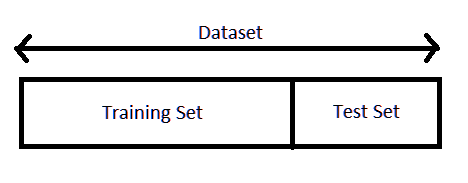

Y se puede hacer validación cruzada repitiendo este proceso de dividir los datos en dos conjuntos varias veces y luego hacer la media de los resultados.

En los sistemas de recomendación generamos nuestro "conjunto de entrenamiento" enmascarando interacciones aleatorias en nuestra matriz usuario-elemento. En otras palabras, hacemos como que no sabemos si a un usuario le gustó una cierta Película "A", pero en realidad sí lo sabemos. Una vez que entrenamos nuestro modelo y generamos nuestras predicciones de calificación, podemos comparar nuestra calificación prevista con la calificación real.

Hay varias formas de comparar la calificación (rating) calculado por el sistema con la calificación real (que sabemos). Las más comunes son:
    
1) Error cuadrático medio (RMSE, Root Mean Squared Error): $\text{RMSE} = \sqrt{\frac{\Sigma^N_{i=1}(y-\hat{y})^2}{N}}$

2) Precision: $\text{Precision} = \frac{TP}{TP+FP}$

3) Recall: $\text{Recall} = \frac{TP}{TP+FN}$